# TESTING MODELS

Let us try a few classification models
## Classical ML models

In [1]:
import pandas as pd
import time
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
models = []

In [3]:
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((74462, 54),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'nationality_log', 'mom_occup_log', 'edu_spl_need_log',
        'has_student_debt_log', 'no_fee_dues_log', 'got_scholarship_log',
        'age_at_start_log', 'sem1_units_credite

We use only the selected features

In [4]:
X,y = df.drop(columns=['Target','id','nationality']).values, df['Target'].values

(Target
 Graduate    36433
 Dropout     23325
 Enrolled    14704
 Name: count, dtype: int64,
 <Axes: >)

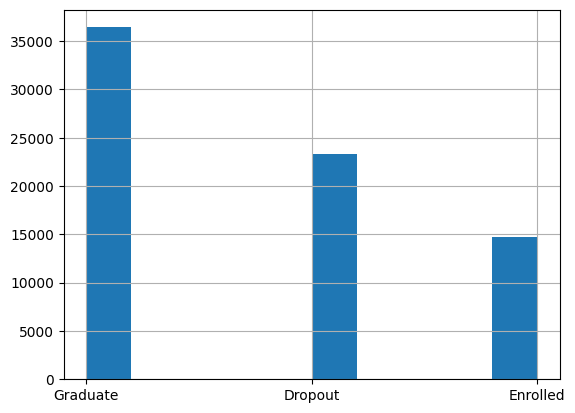

In [5]:
df['Target'].value_counts(), df['Target'].hist()

So we have an imbalanced dataset. To handle this - for classical ML models, we oversample the smaller classes

In [6]:
# Train test split
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_l = le.fit(y)
y_enc = y_l.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

### Decision tree

First we check the performance without any oversampling

In [7]:
from sklearn import tree

In [8]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train,y_train)
end = time.perf_counter()

CPU times: total: 922 ms
Wall time: 1.06 s


In [9]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9364,   894],
        [  845,  3790]],

       [[10432,  1492],
        [ 1400,  1569]],

       [[ 6435,  1169],
        [ 1310,  5979]]], dtype=int64)

In [10]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7221431230021699, 0.7612972537433693)

In [11]:
print('DECISION TREE - NO PREPROCESSING')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - NO PREPROCESSING


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.05477


Next, let us use `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority classes

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
#Apply Over Sampling
print(f'Before Oversampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)
print(f'After Oversampling {sorted(Counter(y_train1).items())}')

Before Oversampling [(0, 18690), (1, 11735), (2, 29144)]
After Oversampling [(0, 29144), (1, 29144), (2, 29144)]


In [14]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 3.67 s
Wall time: 3.85 s


In [15]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9369,   889],
        [  873,  3762]],

       [[10387,  1537],
        [ 1365,  1604]],

       [[ 6474,  1130],
        [ 1318,  5971]]], dtype=int64)

In [16]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7236931044276739, 0.7612301081044787)

In [17]:
print('DECISION TREE - SMOTE')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_oversampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - SMOTE


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142


Let us try an undersampler

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=0)
print(f'Before Undersampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 =rus.fit_resample(X_train, y_train)
print(f'After Undersampling {sorted(Counter(y_train1).items())}')

Before Undersampling [(0, 18690), (1, 11735), (2, 29144)]
After Undersampling [(0, 11735), (1, 11735), (2, 11735)]


In [20]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 484 ms
Wall time: 778 ms


In [21]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[9390,  868],
        [ 922, 3713]],

       [[9619, 2305],
        [1043, 1926]],

       [[6783,  821],
        [2029, 5260]]], dtype=int64)

In [22]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7238057855565142, 0.7318203182703283)

In [23]:
print('DECISION TREE - Random Undersampler')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_undersampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - Random Undersampler


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214


So, the performance is not vastly affected by the oversampling or undersampling => Decision tree is robust to imbalanced data

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.6162093999992067s, accuracy: 0.804001880077889
n_estimators: 10, time_taken: 1.1735269000018889s, accuracy: 0.8183039011616196
n_estimators: 20, time_taken: 2.381616999999096s, accuracy: 0.8281743100785603
n_estimators: 50, time_taken: 5.77274799999941s, accuracy: 0.8344188544954005
n_estimators: 100, time_taken: 11.361902100001316s, accuracy: 0.8358289129121064
n_estimators: 200, time_taken: 22.25403940000251s, accuracy: 0.8363660780232324
n_estimators: 300, time_taken: 35.01019670000096s, accuracy: 0.8370375344121399


Pick best model

In [26]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 37.33499699999811s, accuracy: 0.8369032431343584


In [27]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197


Text(0.5, 1.0, 'Training time')

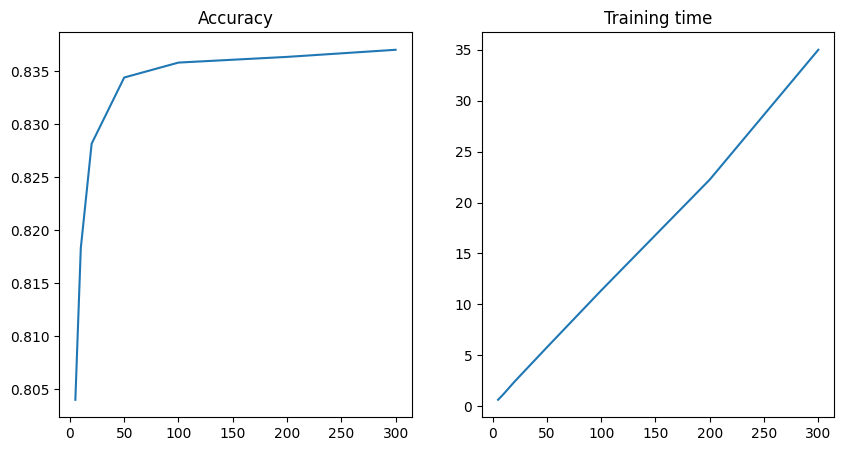

In [28]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')

Try with SMOTE

In [29]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 1.711980100000801s, accuracy: 0.800711743772242
n_estimators: 10, time_taken: 3.3994600999976683s, accuracy: 0.8198482508561069
n_estimators: 20, time_taken: 6.701393899998948s, accuracy: 0.8260256496340562
n_estimators: 50, time_taken: 18.319298399997933s, accuracy: 0.8324716309675687
n_estimators: 100, time_taken: 32.98988280000049s, accuracy: 0.8344860001342913
n_estimators: 200, time_taken: 80.94888179999907s, accuracy: 0.8349560196065265
n_estimators: 300, time_taken: 122.86633029999939s, accuracy: 0.8354260390787618


Pick best model

In [30]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 300, time_taken: 122.50176519999877s, accuracy: 0.8338145437453838


In [31]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330


Text(0.5, 1.0, 'Training time')

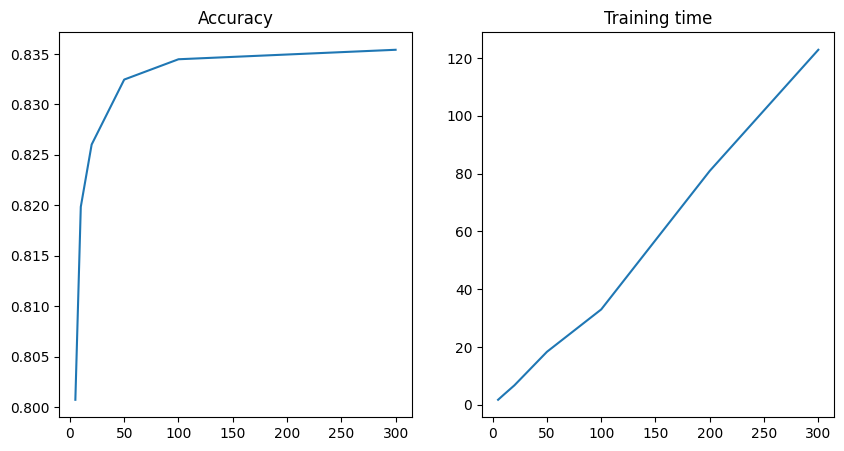

In [32]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


Let's try Undersampling

In [33]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 0.44251290000102017s, accuracy: 0.7764721681326798
n_estimators: 10, time_taken: 0.9050316000029852s, accuracy: 0.7969515879943597
n_estimators: 20, time_taken: 1.8506123999977717s, accuracy: 0.8066205599946283
n_estimators: 50, time_taken: 4.488022999998066s, accuracy: 0.8114550459947626
n_estimators: 100, time_taken: 9.058499399998254s, accuracy: 0.8144094541059558
n_estimators: 200, time_taken: 17.02805619999708s, accuracy: 0.8171624253004768
n_estimators: 300, time_taken: 25.618703299998742s, accuracy: 0.8154837843282079


Pick best model

In [34]:
model1 = RandomForestClassifier(n_estimators=estims[np.argmax(acc)],warm_start=True)
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {estims[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')

n_estimators: 200, time_taken: 17.34312570000111s, accuracy: 0.8156180756059894


In [35]:
model.feature_importances_

array([0.0008745 , 0.01186795, 0.00876311, 0.01681078, 0.00097427,
       0.00197605, 0.02750683, 0.01449029, 0.01455011, 0.01348698,
       0.03198259, 0.00579219, 0.00040198, 0.00451769, 0.01492717,
       0.00666729, 0.01464388, 0.01843687, 0.00187962, 0.01016381,
       0.03769603, 0.07461531, 0.07953684, 0.00174207, 0.00150028,
       0.0112673 , 0.04147363, 0.11700634, 0.11848896, 0.00173152,
       0.01609303, 0.0145077 , 0.01625605, 0.00088329, 0.00888928,
       0.01704257, 0.00096642, 0.00199011, 0.00046036, 0.01348072,
       0.00040375, 0.00451707, 0.01551235, 0.01199841, 0.01790993,
       0.00174945, 0.06409989, 0.00173308, 0.00144301, 0.08255959,
       0.00173169])

In [36]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703


Text(0.5, 1.0, 'Training time')

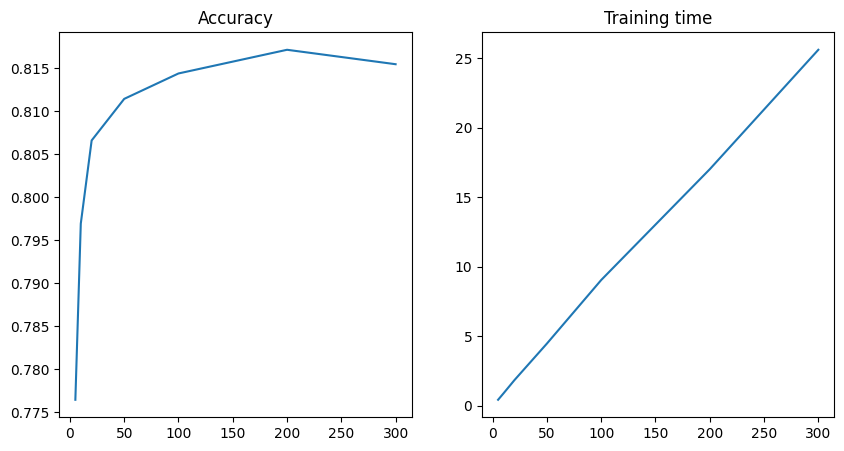

In [37]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


### Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train, y_train)
end = time.perf_counter()

CPU times: total: 0 ns
Wall time: 53.6 ms


In [40]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9632,   626],
        [ 1042,  3593]],

       [[10596,  1328],
        [ 1536,  1433]],

       [[ 5994,  1610],
        [  986,  6303]]], dtype=int64)

In [41]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7075235150450866, 0.7606929429933525)

In [42]:
print('NAIVE BAYES - No preprocessing')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Naive_Bayes_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

NAIVE BAYES - No preprocessing


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947


Let's try oversampling 

In [43]:
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)

In [44]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 188 ms
Wall time: 99.4 ms


In [45]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9565,   693],
        [ 1027,  3608]],

       [[10077,  1847],
        [ 1109,  1860]],

       [[ 6580,  1024],
        [ 1428,  5861]]], dtype=int64)

In [46]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7363289798005573, 0.7606929429933525)

In [47]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476


Let's try undersampling

In [48]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train, y_train)

In [49]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 0 ns
Wall time: 42.4 ms


In [50]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9648,   610],
        [ 1050,  3585]],

       [[10459,  1465],
        [ 1373,  1596]],

       [[ 6195,  1409],
        [ 1061,  6228]]], dtype=int64)

In [51]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7218185699814379, 0.7660645941046129)

In [52]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847


### K Nearest Neighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.012215599999763072s, accuracy: 0.7351104545759752
n_neighbors: 5, time_taken: 0.009230899999238318s, accuracy: 0.7465923588262943
n_neighbors: 10, time_taken: 0.00713980000000447s, accuracy: 0.7522997381320083
n_neighbors: 15, time_taken: 0.006016499999532243s, accuracy: 0.7528369032431343
n_neighbors: 20, time_taken: 0.006942599997273646s, accuracy: 0.751023970993084
n_neighbors: 25, time_taken: 0.012110200001188787s, accuracy: 0.750218223326395
n_neighbors: 50, time_taken: 0.007391099999949802s, accuracy: 0.7377291344927147
n_neighbors: 100, time_taken: 0.015967899998940993s, accuracy: 0.7227556570200765
n_neighbors: 200, time_taken: 0.0076456999995571095s, accuracy: 0.7054992278251527
n_neighbors: 400, time_taken: 0.006112700000812765s, accuracy: 0.683341166991204
n_neighbors: 800, time_taken: 0.006583200000022771s, accuracy: 0.6509769690458604


Pick best model

In [55]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train,y_train)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.010772000001452398s, accuracy: 0.7528369032431343


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [56]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


Text(0.5, 1.0, 'Training time')

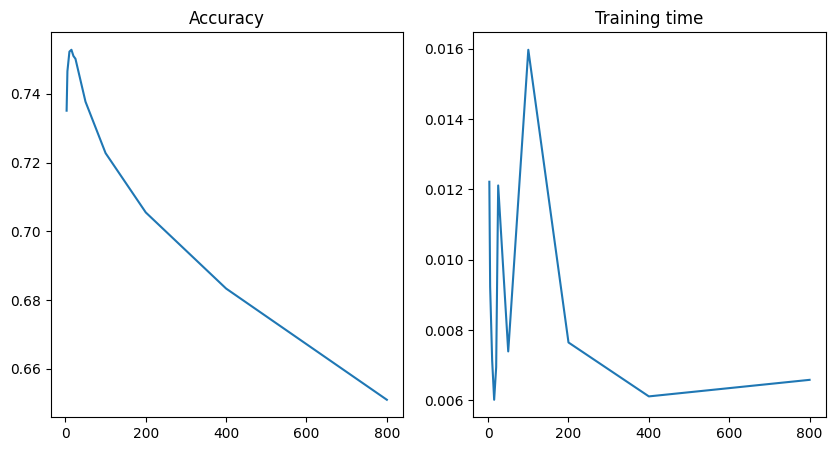

In [57]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try oversampling

In [58]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [59]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.013270200000988552s, accuracy: 0.7006647418250185
n_neighbors: 5, time_taken: 0.008411800001340453s, accuracy: 0.701873363325052
n_neighbors: 10, time_taken: 0.00934160000178963s, accuracy: 0.7021419458806151
n_neighbors: 15, time_taken: 0.00953289999961271s, accuracy: 0.7106694420197408
n_neighbors: 20, time_taken: 0.00899339999887161s, accuracy: 0.7088565097696905
n_neighbors: 25, time_taken: 0.0295083999990311s, accuracy: 0.7093265292419257
n_neighbors: 50, time_taken: 0.009265600001526764s, accuracy: 0.6946887799637413
n_neighbors: 100, time_taken: 0.008455200000753393s, accuracy: 0.6864970120190693
n_neighbors: 200, time_taken: 0.017085499999666354s, accuracy: 0.675417981602095
n_neighbors: 400, time_taken: 0.010068100000353297s, accuracy: 0.6611831061572551
n_neighbors: 800, time_taken: 0.013573199998063501s, accuracy: 0.6361377828510039


Pick best model

In [60]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 15, time_taken: 0.009545900000375696s, accuracy: 0.7106694420197408


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=15)>

In [61]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


Text(0.5, 1.0, 'Training time')

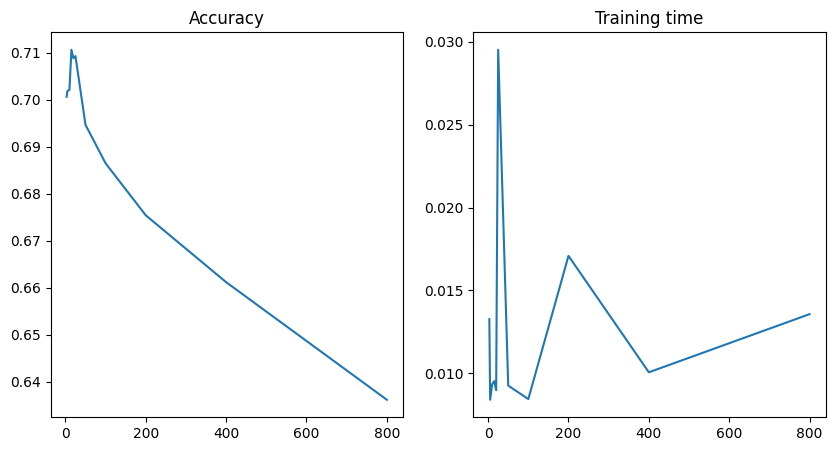

In [62]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try undersampling

In [63]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [64]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.0035022000010940246s, accuracy: 0.6941516148526153
n_neighbors: 5, time_taken: 0.004147999999986496s, accuracy: 0.6979789162693883
n_neighbors: 10, time_taken: 0.0034904999993159436s, accuracy: 0.7061035385751695
n_neighbors: 15, time_taken: 0.004260300000169082s, accuracy: 0.7046934801584637
n_neighbors: 20, time_taken: 0.0031156000004557427s, accuracy: 0.7002618679916739
n_neighbors: 25, time_taken: 0.05718730000080541s, accuracy: 0.6961659840193379
n_neighbors: 50, time_taken: 0.007226699999591801s, accuracy: 0.6853555361579265
n_neighbors: 100, time_taken: 0.004361200000857934s, accuracy: 0.6717921171019943
n_neighbors: 200, time_taken: 0.003848299998935545s, accuracy: 0.6546699791848519
n_neighbors: 400, time_taken: 0.0027674000011757016s, accuracy: 0.6283488887396763
n_neighbors: 800, time_taken: 0.004218100002617575s, accuracy: 0.5983347881555093


Pick best model

In [65]:
model1 = KNeighborsClassifier(n_neighbors=nbors[np.argmax(acc)])
start = time.perf_counter()
model1.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model1.predict(X_val)
_acc = accuracy_score(y_val,y_pred)
print(f'n_estimators: {nbors[np.argmax(acc)]}, time_taken: {end-start}s, accuracy: {_acc}')
model1.get_params

n_estimators: 10, time_taken: 0.008452199999737786s, accuracy: 0.7061035385751695


<bound method BaseEstimator.get_params of KNeighborsClassifier(n_neighbors=10)>

In [66]:
y_pred = model1.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


Text(0.5, 1.0, 'Training time')

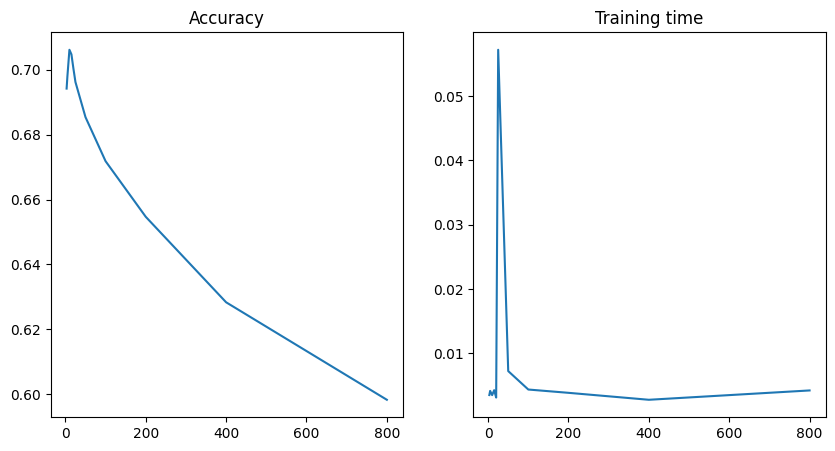

In [67]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

### LightGBM

In [68]:
from lightgbm import LGBMClassifier

In [69]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train,y_train)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 59569, number of used features: 51
[LightGBM] [Info] Start training from score -1.159147
[LightGBM] [Info] Start training from score -1.624559
[LightGBM] [Info] Start training from score -0.714886
CPU times: total: 8.48 s
Wall time: 1.41 s


1.384688099999039

In [70]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9998,   260],
        [  799,  3836]],

       [[10928,   996],
        [ 1023,  1946]],

       [[ 6515,  1089],
        [  523,  6766]]], dtype=int64)

In [71]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8037678508042226, 0.8425434768011818)

In [72]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 59569, number of used features: 51
[LightGBM] [Info] Start training from score -1.159147
[LightGBM] [Info] Start training from score -1.624559
[LightGBM] [Info] Start training from score -0.714886
n_estims: 5, time_taken: 0.514803000001848s, accuracy: 0.8121936480225609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 59569, number of used features: 51
[LightGBM] [Info] Start training from score -1.159147
[Lig

In [73]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train,y_train)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 59569, number of used features: 51
[LightGBM] [Info] Start training from score -1.159147
[LightGBM] [Info] Start training from score -1.624559
[LightGBM] [Info] Start training from score -0.714886


In [74]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_no_preprocessing', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


Try SMOTE

In [75]:
X_train1,y_train1 = SMOTE().fit_resample(X_train,y_train)

In [76]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11920
[LightGBM] [Info] Number of data points in the train set: 87432, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 1min 5s
Wall time: 8.07 s


8.073831400000927

In [77]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10002,   256],
        [  812,  3823]],

       [[10891,  1033],
        [  996,  1973]],

       [[ 6539,  1065],
        [  546,  6743]]], dtype=int64)

In [78]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.804812445749652, 0.8419391660511649)

In [79]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11920
[LightGBM] [Info] Number of data points in the train set: 87432, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
n_estims: 5, time_taken: 0.8943204999995942s, accuracy: 0.8236084066339892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11920
[LightGBM] [Info] Number of data points in the train set: 87432, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] 

In [80]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train1,y_train1)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11920
[LightGBM] [Info] Number of data points in the train set: 87432, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [81]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


Try Undersampling

In [82]:
X_train1,y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [83]:
%%time
model = LGBMClassifier()
start = time.perf_counter()
model.fit(X_train1,y_train1)
end = time.perf_counter()
end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 35205, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
CPU times: total: 14.1 s
Wall time: 3.86 s


3.859562800000276

In [84]:
y_pred = model.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[10109,   149],
        [  935,  3700]],

       [[10105,  1819],
        [  579,  2390]],

       [[ 6943,   661],
        [ 1115,  6174]]], dtype=int64)

In [85]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.8167628721422487, 0.8234741153562076)

In [86]:
tim, acc = [], []
model_lg = LGBMClassifier()

for n in estims:
    model_lg = LGBMClassifier(n_estimators=n)
    start = time.perf_counter()
    model_lg.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_lg.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estims: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 35205, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
n_estims: 5, time_taken: 0.3995826999998826s, accuracy: 0.8102464244947291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 35205, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[Li

In [87]:
n = estims[np.argmax(acc)]
model_lgbm = LGBMClassifier(n_estimators=n)
model_lgbm.fit(X_train1,y_train1)
y_pred = model_lgbm.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 35205, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [88]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'LightGBM_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.8091374893253629, 'recal...",1.054770
1,Decision_tree_oversampling,"{'0': {'precision': 0.8088583100408514, 'recal...",3.844142
2,Decision_tree_undersampling,"{'0': {'precision': 0.8105217201484392, 'recal...",0.777214
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.9438993710691824, 'recal...",35.010197
4,RandomForest_oversampling,"{'0': {'precision': 0.9486658195679797, 'recal...",122.866330
5,RandomForest_undersampling,"{'0': {'precision': 0.9703903095558546, 'recal...",25.618703
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8516236074899265, 'recal...",0.062947
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8388746803069054, 'recal...",0.090476
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8545887961859356, 'recal...",0.048847
9,KNN_no_preprocessing,"{'0': {'precision': 0.8917525773195877, 'recal...",0.010772


### XGBoost

In [89]:
from xgboost import XGBClassifier

from xgboost import plot_importance

In [90]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train,y_train)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 2.5132644000004802s
CPU times: total: 15.6 s
Wall time: 2.52 s


In [91]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9302    0.8306    0.8776      4635
           1     0.6614    0.6541    0.6577      2969
           2     0.8636    0.9263    0.8939      7289

    accuracy                         0.8423     14893
   macro avg     0.8184    0.8037    0.8097     14893
weighted avg     0.8440    0.8423    0.8417     14893



Try SMOTE

In [92]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [93]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train1,y_train1)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 4.774547799999709s
CPU times: total: 34.5 s
Wall time: 4.78 s


In [94]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9276    0.8298    0.8760      4635
           1     0.6597    0.6588    0.6593      2969
           2     0.8657    0.9243    0.8940      7289

    accuracy                         0.8419     14893
   macro avg     0.8177    0.8043    0.8098     14893
weighted avg     0.8439    0.8419    0.8416     14893



Try undersampling

In [95]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [96]:
%%time
model_xgb = XGBClassifier(booster='gbtree')
start = time.perf_counter()
model_xgb.fit(X_train1,y_train1)
end = time.perf_counter()
print(f'Training time: {end-start}s')

Training time: 1.9033457000005s
CPU times: total: 13.6 s
Wall time: 1.91 s


In [97]:
y_pred = model_xgb.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))))
print(x)

              precision    recall  f1-score   support

           0     0.9492    0.8067    0.8722      4635
           1     0.5674    0.7912    0.6609      2969
           2     0.9012    0.8425    0.8709      7289

    accuracy                         0.8211     14893
   macro avg     0.8059    0.8135    0.8013     14893
weighted avg     0.8496    0.8211    0.8294     14893



## Results

In [98]:
df_results = pd.DataFrame(models)

In [99]:
df_results['precision'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['precision'],3), 1: round(x['1']['precision'],3), 2: round(x['2']['precision'],3)})
df_results['recall'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['recall'],3), 1: round(x['1']['recall'],3), 2: round(x['2']['recall'],3)})
df_results['f1-score'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['f1-score'],3), 1: round(x['1']['f1-score'],3), 2: round(x['2']['f1-score'],3)})
df_results['macro_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['macro avg'][k],3) for k in x['macro avg'].keys()})
df_results['weighted_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['weighted avg'][k],3) for k in x['weighted avg'].keys()})
df_results['accuracy'] = df_results['metrics'].apply(lambda x: round(x['accuracy'],3))
df_results['time (s)'] = df_results['training_time(s)']
df_results.drop(columns=['metrics','training_time(s)'],inplace=True)

In [100]:
df_results.to_csv('data/benchmarking_outliers_handled.csv',index=False)
df_results

,model,precision,recall,f1-score,macro_avg,weighted_avg,accuracy,time (s)
0,Decision_tree_no_preprocessing,"{0: 0.809, 1: 0.513, 2: 0.836}","{0: 0.818, 1: 0.528, 2: 0.82}","{0: 0.813, 1: 0.52, 2: 0.828}","{'precision': 0.719, 'recall': 0.722, 'f1-scor...","{'precision': 0.763, 'recall': 0.761, 'f1-scor...",0.761,1.054770
1,Decision_tree_oversampling,"{0: 0.809, 1: 0.511, 2: 0.841}","{0: 0.812, 1: 0.54, 2: 0.819}","{0: 0.81, 1: 0.525, 2: 0.83}","{'precision': 0.72, 'recall': 0.724, 'f1-score...","{'precision': 0.765, 'recall': 0.761, 'f1-scor...",0.761,3.844142
2,Decision_tree_undersampling,"{0: 0.811, 1: 0.455, 2: 0.865}","{0: 0.801, 1: 0.649, 2: 0.722}","{0: 0.806, 1: 0.535, 2: 0.787}","{'precision': 0.71, 'recall': 0.724, 'f1-score...","{'precision': 0.766, 'recall': 0.732, 'f1-scor...",0.732,0.777214
3,RandomForest_no_preprocessing,"{0: 0.944, 1: 0.647, 2: 0.854}","{0: 0.809, 1: 0.649, 2: 0.931}","{0: 0.872, 1: 0.648, 2: 0.891}","{'precision': 0.815, 'recall': 0.797, 'f1-scor...","{'precision': 0.841, 'recall': 0.837, 'f1-scor...",0.837,35.010197
4,RandomForest_oversampling,"{0: 0.949, 1: 0.627, 2: 0.862}","{0: 0.805, 1: 0.681, 2: 0.914}","{0: 0.871, 1: 0.653, 2: 0.887}","{'precision': 0.812, 'recall': 0.8, 'f1-score'...","{'precision': 0.842, 'recall': 0.834, 'f1-scor...",0.834,122.866330
5,RandomForest_undersampling,"{0: 0.97, 1: 0.553, 2: 0.899}","{0: 0.778, 1: 0.81, 2: 0.842}","{0: 0.863, 1: 0.657, 2: 0.869}","{'precision': 0.807, 'recall': 0.81, 'f1-score...","{'precision': 0.852, 'recall': 0.815, 'f1-scor...",0.815,25.618703
6,Naive_Bayes_no_preprocessing,"{0: 0.852, 1: 0.519, 2: 0.797}","{0: 0.775, 1: 0.483, 2: 0.865}","{0: 0.812, 1: 0.5, 2: 0.829}","{'precision': 0.722, 'recall': 0.708, 'f1-scor...","{'precision': 0.758, 'recall': 0.761, 'f1-scor...",0.761,0.062947
7,Naive_Bayes_oversampling,"{0: 0.839, 1: 0.502, 2: 0.851}","{0: 0.778, 1: 0.626, 2: 0.804}","{0: 0.808, 1: 0.557, 2: 0.827}","{'precision': 0.731, 'recall': 0.736, 'f1-scor...","{'precision': 0.778, 'recall': 0.761, 'f1-scor...",0.761,0.090476
8,Naive_Bayes_undersampling,"{0: 0.855, 1: 0.521, 2: 0.816}","{0: 0.773, 1: 0.538, 2: 0.854}","{0: 0.812, 1: 0.529, 2: 0.835}","{'precision': 0.73, 'recall': 0.722, 'f1-score...","{'precision': 0.769, 'recall': 0.766, 'f1-scor...",0.766,0.048847
9,KNN_no_preprocessing,"{0: 0.892, 1: 0.531, 2: 0.759}","{0: 0.709, 1: 0.458, 2: 0.901}","{0: 0.79, 1: 0.492, 2: 0.824}","{'precision': 0.727, 'recall': 0.689, 'f1-scor...","{'precision': 0.755, 'recall': 0.753, 'f1-scor...",0.753,0.010772


In [101]:
def get_results(df):

    fields = {'model':df['model'].values, 'precision':[x['precision'] for x in df['macro_avg'].values],
                'recall':[x['recall'] for x in df['macro_avg'].values], 'f1-score':[x['f1-score'] for x in df['macro_avg'].values],
                'accuracy':df['accuracy'].values, 'time (s)': df['time (s)']}
    
    return pd.DataFrame(fields)

In [102]:
res = get_results(df_results)
res

,model,precision,recall,f1-score,accuracy,time (s)
0,Decision_tree_no_preprocessing,0.719,0.722,0.721,0.761,1.054770
1,Decision_tree_oversampling,0.720,0.724,0.722,0.761,3.844142
2,Decision_tree_undersampling,0.710,0.724,0.709,0.732,0.777214
3,RandomForest_no_preprocessing,0.815,0.797,0.804,0.837,35.010197
4,RandomForest_oversampling,0.812,0.800,0.804,0.834,122.866330
5,RandomForest_undersampling,0.807,0.810,0.797,0.815,25.618703
6,Naive_Bayes_no_preprocessing,0.722,0.708,0.714,0.761,0.062947
7,Naive_Bayes_oversampling,0.731,0.736,0.731,0.761,0.090476
8,Naive_Bayes_undersampling,0.730,0.722,0.725,0.766,0.048847
9,KNN_no_preprocessing,0.727,0.689,0.702,0.753,0.010772
